In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time
from datetime import datetime, timedelta

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [2]:
df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")
df_eddies


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.093546,-29.714998,261,275,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.871720,-29.764770,258,273,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.922307,-29.791470,259,272,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.955011,-29.644446,259,276,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.900960,-29.634113,258,276,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132634,10646,2962,CE,155.090978,-40.102161,223,14,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132635,10647,2962,CE,154.836115,-40.385267,220,6,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132636,10648,2962,CE,154.979715,-40.569836,223,3,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132637,10649,2962,CE,155.150873,-40.263961,224,11,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


#### Sample
AE Downstream: 2749, 8
\
AE Upstream: 2504, 896
\
CE Downstream: 1394, 382
\
CE Upstream: 1967, 926 (reasonable)

In [3]:
sample_eddies = [2749, 8, 2504, 896, 1394, 382, 1967, 926]

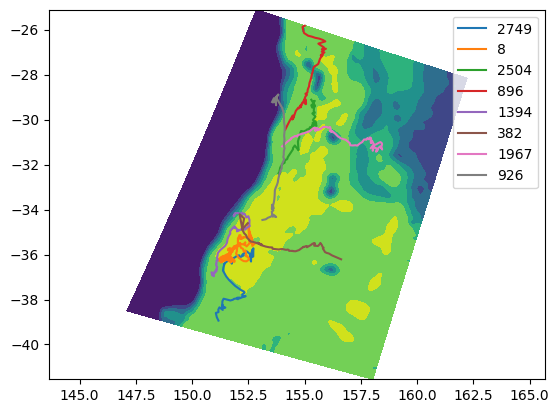

In [4]:
plt.contourf(lon_rho, lat_rho, h)
plt.axis('equal')

for eddy in sample_eddies:
    df = df_eddies[df_eddies['ID']==eddy].copy()
    plt.plot(df['Lon'], df['Lat'], label=eddy)

plt.legend()


In [5]:
df

,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
42736,4462,926,CE,153.552369,-29.220617,81,235,217.055550,1160.138887,-0.014492,-0.003058,-0.002151,-0.033286,68,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
42737,4463,926,CE,153.593529,-29.135800,81,237,217.767201,1170.307652,NaN,NaN,NaN,NaN,68,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
42738,4464,926,CE,153.634689,-29.050983,82,239,218.478853,1180.476417,-0.034866,-0.004292,-0.003864,-0.077459,68,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
42739,4465,926,CE,153.656307,-29.132167,84,237,223.389418,1172.757440,-0.038468,-0.001852,-0.004655,-0.086246,68,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
42740,4466,926,CE,153.600187,-29.240663,83,235,222.157835,1159.634291,-0.031982,0.000033,-0.003193,-0.070351,68,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42799,4525,926,CE,153.568623,-34.268385,149,129,395.288869,634.932731,-0.005763,-0.000003,-0.002995,-0.017518,68,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
42800,4526,926,CE,153.480116,-34.323838,147,127,389.435926,626.360220,-0.004707,0.001228,-0.003583,-0.016580,68,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
42801,4527,926,CE,153.367804,-34.367155,144,125,381.103082,618.311950,-0.002881,0.000988,-0.004492,-0.014746,68,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
42802,4528,926,CE,153.273815,-34.433542,142,123,375.164107,608.433805,-0.002070,0.000366,-0.004717,-0.013574,68,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


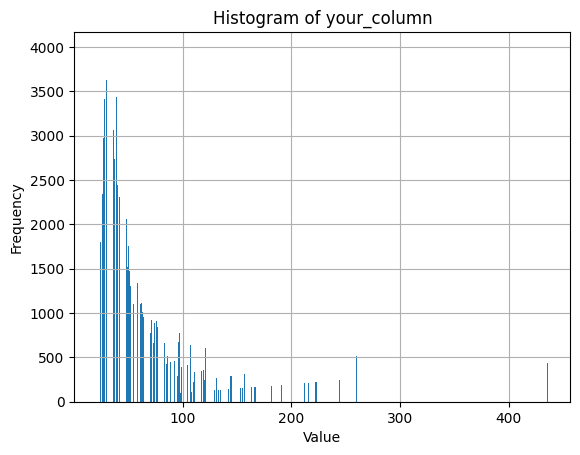

In [7]:
df_eddies['Age'].hist(bins=1000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of your_column')
plt.show()